In [ ]:
import os, sys, time, importlib, json, copy
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from OuterDeployment.HarrisCorner import *
from SensorModule.Sensor import Sensor
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [ ]:
# 사용할 알고리즘
from InnerDeployment.GeneticAlgorithm.main import SensorGA

In [ ]:
vis=VisualTool(show=True, size=(3,3), save=False)

전체 맵데이터 레이아웃 파악

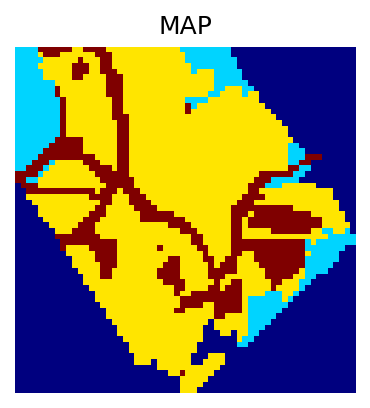

In [ ]:
map=MapLoader().load("gangjin.crop1")
vis.showJetMap(map)

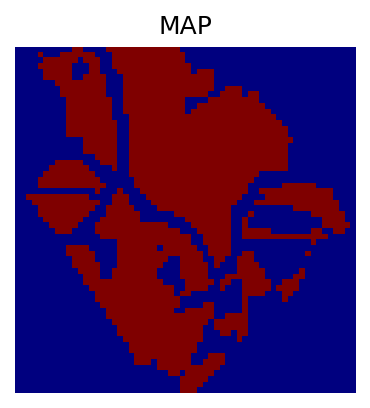

In [ ]:
installable_layer = layer_map(map, keep_values=[2])
vis.showJetMap(installable_layer)

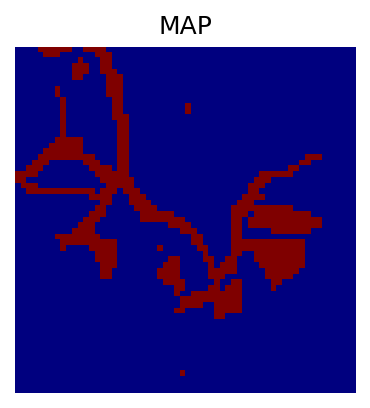

In [ ]:
road_layer = layer_map(map, keep_values=[3])
vis.showJetMap(road_layer)

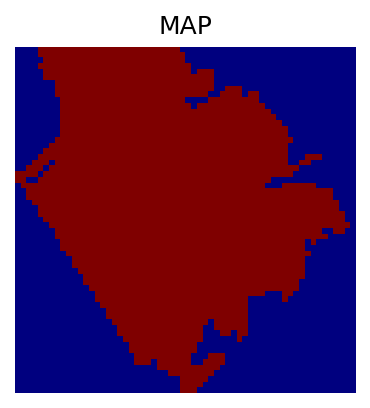

In [ ]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.showJetMap(jobsite_layer)

센서가 설치가능한 구역 중에서 최외곽센서 설치 가능 지점 탐색

In [ ]:
corner_layer = HarrisCorner(map)
corner_candidate = corner_layer.run(installable_layer, blockSize=3, ksize=3, k=0.1, dilate_size=7)

[(30, 2), (5, 3), (35, 6), (17, 8), (11, 19), (18, 20), (46, 20), (5, 22), (45, 26), (13, 30), (26, 30), (54, 32), (11, 36), (16, 37), (36, 38), (27, 39), (41, 43), (30, 44), (38, 48)]
19 <class 'list'>


설치 가능한 지점 위에서만 후보 추출하는 과정(코너 후보 지점들이 정확한 코너지점들 추출이 안되서..)

In [ ]:
installable = np.asarray(installable_layer).astype(bool)  # True = installable

H, W = installable.shape
corner_candidate = [
    (x, y) for (x, y) in corner_candidate
    if 0 <= x < W and 0 <= y < H and installable[y, x]
]


print("Outmost corner points:", len(corner_candidate))
vis.showJetMap_circle(map, corner_candidate, radius=45)

In [ ]:
# -------------------------
# GA inputs (normalize)
# -------------------------
site_map = map  # map 변수명 그대로 써도 되지만, 파이썬 built-in map()과 겹쳐서 별칭 권장

installable_map = (np.asarray(installable_layer) > 0).astype(np.uint8)  # 0/1
jobsite_map     = (np.asarray(jobsite_layer) > 0).astype(np.uint8)      # 0/1

# corner 좌표 정리 (중복 제거 + int 보장)
corner_positions = [(int(x), int(y)) for (x, y) in corner_candidate]
corner_positions = list(dict.fromkeys(corner_positions))  # order 유지 중복 제거

print("corner_positions:", len(corner_positions))

# -------------------------
# GA parameters
# -------------------------
coverage = 45          # 지금 vis.circle radius랑 맞추고 싶으면 동일 값 사용
generations = 100

ga = SensorGA(
    installable_map=installable_map,
    jobsite_map=jobsite_map,
    coverage=coverage,
    generations=generations,
    corner_positions=corner_positions,

    # population
    initial_size=100,
    selection_size=50,
    child_chromo_size=100,

    # chromosome length (inner sensors)
    min_sensors=10,
    max_sensors=100,

    # FitnessFunc kwargs (fitnessfunction.py 기준 키만)
    fitness_kwargs=dict(
        useCache=True,
        sampleCount=25,     # None이면 전수(느림), 20~40 권장
        gainLimit=0.01,     # greedy ordering에서 gain이 너무 작으면 중단
    ),

    # mutation 기본 knobs(필요시 run()에서 override 가능)
    mutation_kwargs=dict(
        p_add=0.40,
        p_del=0.30,
        p_move=0.30,
        min_coverage_keep=90.0,  # delete/move 후 coverage 떨어지면 rollback
    ),
)
